In [ ]:
import pandas as pd;
import numpy  as np;

import matplotlib.pyplot as plt;
import scipy.integrate; 
from   scipy.integrate import solve_ivp
from   scipy.optimize  import minimize, differential_evolution

import copy;

from CovidData import CovidData;
from SIR_plots import SIRD_plots;
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split, RandomizedSearchCV;
from sklearn.preprocessing   import PolynomialFeatures;
from sklearn.linear_model    import BayesianRidge;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def SIRD_model (y, t, beta, gamma, mu, pop):
    S, I, R, D = y;
    dS_dt   = (-beta*S*I)/pop;
    dI_dt   = (((beta*S*I)/pop) - (gamma*I)) - (mu*I)
    dR_dt   = (gamma*I);
    dD_dt   = (mu*I)
    return    ([ dS_dt , dI_dt , dR_dt, dD_dt ]);

In [ ]:
def get_SIRD_initials (SIR_df):
    '''
    get_SIR_initials retrieves the inital S I R values from a time series dataframe
    Parameters: 
    \t1) SIR_df is a timeseries dataframe that contains S I R values
    '''
    SIR_0 = list(SIR_df.iloc[0 , :]);
    SIR_0 = [SIR_0[0],1,0,0]
    return SIR_0[0] , SIR_0[1], SIR_0[2], SIR_0[3]

In [ ]:
def betaGamaMuMinimization(point, data, s0, i0, r0, d0, pop):
    '''
    The betaGamaMuMinimization function was written to be minimized based on the RMSE between 
    \t- the Calculated Infected cases and the Estimated Infected cases with the given Beta and Gamma.
    \t- the Actual Recovered cases and the Estimated Recovered cases with the given Beta and Gamma.
    '''
    beta, gamma, mu = point
    size = len(data)
    
    def SIRD(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return [(-beta*S*I/pop), (beta*S*I/pop) - gamma*I - mu*I,gamma*I, mu*I]

    solution = solve_ivp(SIRD, [0, size], [s0, i0, r0, d0], t_eval = np.arange(0, size, 1), vectorized=True);
    
    l0 = np.sqrt(np.mean((solution.y[0] - data['SIR_Suceptible'])**2));
    l1 = np.sqrt(np.mean((solution.y[1] - data['SIR_Infected'  ])**2));
    l2 = np.sqrt(np.mean((solution.y[2] - data['SIR_Recovered' ])**2));
    l3 = np.sqrt(np.mean((solution.y[3] - data['SIR_Deaths'    ])**2));
    
    # Put more emphasis on infected people
    a = .20
    b = .25
    c = .25
    d = .25
    return (a * l0) + (b * l1) + (c * l2) + (d * l3)

In [ ]:

def trainSIRD(countrySIRdf, population, s0, i0, r0, d0):
    # Local min
    optimal = minimize(betaGamaMuMinimization,[0.001, 0.001, 0.001], args = (countrySIRdf, s0, i0, r0,d0, population), method = 'L-BFGS-B', bounds = [(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
    # Global Min
    #optimal = differential_evolution(betaGamaMuMinimization,bounds = [(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)], args = (countrySIRdf, s0, i0, r0,d0, population), strategy = 'best1bin')
    beta , gamma, mu = optimal.x;
    return beta , gamma, mu

In [ ]:
def setDaysSinceIndex (df):
    dateList = list(df.index);
    days = int(df.shape[0])
    daysSinceLst = [];
    count = 0;
    for i in range(days):
        count+=1;
        daysSinceLst.append(count);
    df = df.set_index(pd.Index(daysSinceLst));
    return df;

def polyBayRidgePredicter (X_train, y, y_train, y_test) :
    tol      = [1e-4, 1e-3, 1e-2];
    alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4];
    alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4];

    bayesian_grid = {'tol'     : tol,
                     'alpha_1' : alpha_1,
                     'alpha_2' : alpha_2,
                     'lambda_1': lambda_1,
                     'lambda_2': lambda_2 }

    poly         = PolynomialFeatures(degree=5);
    poly_y_train = poly.fit_transform(y_train);
    poly_y_test  = poly.fit_transform(y_test);
    poly_y       = poly.fit_transform(y);

    bayesian = BayesianRidge(fit_intercept=False, normalize=True);
    bayesian_search_poly = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
    bayesian_search_poly.fit(poly_y_train, X_train);
    print(bayesian_search_poly.best_params_);
    
    bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
    test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
    bayesian_poly_pred      = bayesian_poly_confirmed.predict(poly_y)

    return bayesian_poly_pred;

def plotPolyBayRidgePrediction(X, y, X_train, y_train, bayesian_poly_pred) :
    #plt.style.use("dark_background");
    plt.figure(figsize=(12, 6))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = 'crimson')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'gold')
    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = '#ff08fb')

    plt.title('Polynomial Bayesian Ridge Regression Prediciton of Infected Population', size=25)
    plt.xlabel('Days Since', size = 15)
    plt.ylabel('# of Infections', size = 15)
    #plt.grid()
    plt.legend(prop = {'size' : 15});
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.savefig("fig.png")
    plt.show()

def plotRidgeAndSIRPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, pop) :
    #plt.style.use("dark_background");
    plt.figure(figsize=(12,6))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = '#ff08fb')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'gold')
    
    time = len(X)
    t = np.linspace(1,time,10000);
    plt.plot(t , solution[:, 1] , label = "SIRD I(t) Prediction" , color = 'cyan');

    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = '#0cfa00')

    plt.title('Prediction Comparison of Infected Population', size=25)
    plt.xlabel('Days Since', size = 20)
    plt.ylabel('# of Infections', size = 20)
    #plt.grid()
    plt.legend(prop = {'size' : 15});
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.savefig("fig1.png")
    plt.show()

def predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, pop) :
    time = df.shape[0]
    t = np.linspace(1,time,10000);
    solution = scipy.integrate.odeint(SIRD_model, [s0, i0, r0, d0], t, args = (beta, gamma, mu, pop))
    solution = np.array(solution);
    return solution;

def trainTestSplitDataFrame (df, trainSize):
    nRows = df.shape[0]
    nTrainRows = nRows*trainSize//100
    nTestRows = nRows - nTrainRows
    trainDf = df.iloc[:nTrainRows , :]
    testDf  = df.iloc[nTrainRows: , :]
    return trainDf , testDf

In [ ]:

def analyzeSIRDtraining(country, pop, trainSize):
    data = CovidData();
    df = data.getSIRD_df(country, pop);
    df =df.iloc[:130 , :]
    df = setDaysSinceIndex(df);
    s0, i0, r0, d0 = get_SIRD_initials(df)
    trainDf , testDf = trainTestSplitDataFrame(df, trainSize)
    beta , gamma, mu = trainSIRD(trainDf, pop, s0, i0, r0, d0);
    solution = predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, pop)
    
    country_plots = SIRD_plots(country, pop, beta, gamma, mu, s0, i0, r0, d0, df);
    country_plots.S_ComparisonTrain(trainDf);
    country_plots.I_ComparisonTrain(trainDf);
    country_plots.R_ComparisonTrain(trainDf);
    country_plots.D_ComparisonTrain(trainDf);
    country_plots.plot_SIRD_model(365);

    X = np.array(df["SIR_Infected"]);
    
    y = np.array(df.index).reshape(-1,1);
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ((100 - trainSize)/100), shuffle = False);
    bayesian_poly_pred = polyBayRidgePredicter(X_train, y, y_train, y_test)
    plotPolyBayRidgePrediction(X, y, X_train, y_train, bayesian_poly_pred)
    plotRidgeAndSIRPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, pop)
    
    return beta, gamma, mu

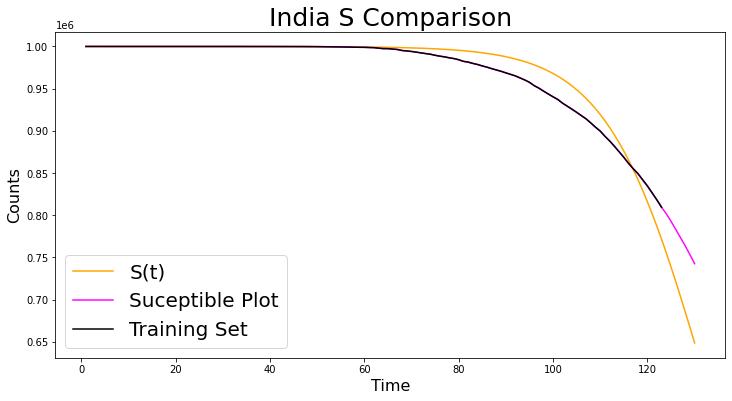

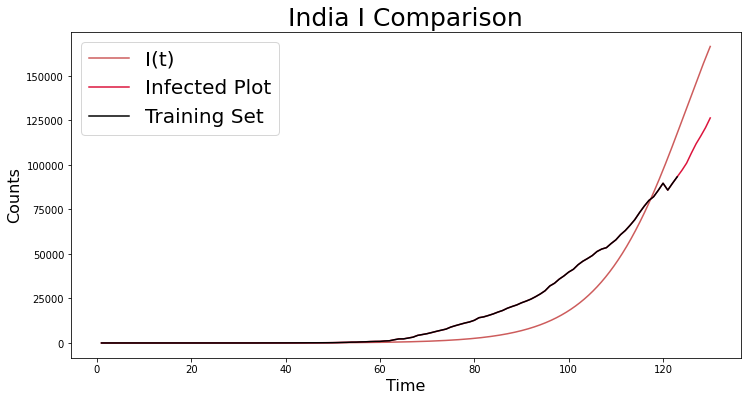

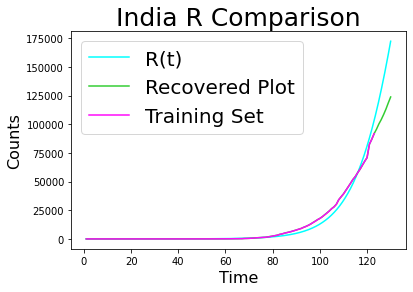

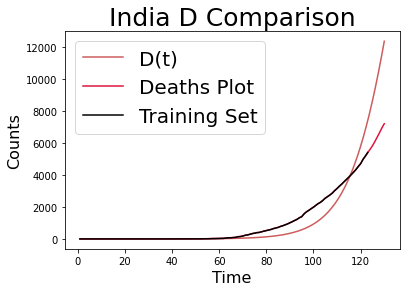

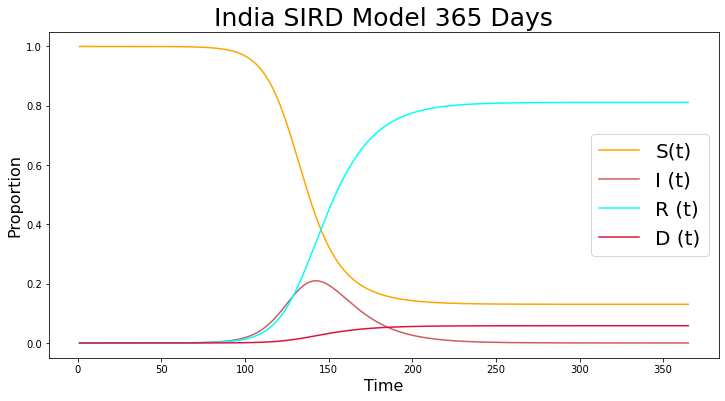

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.0s finished


{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 0.0001}


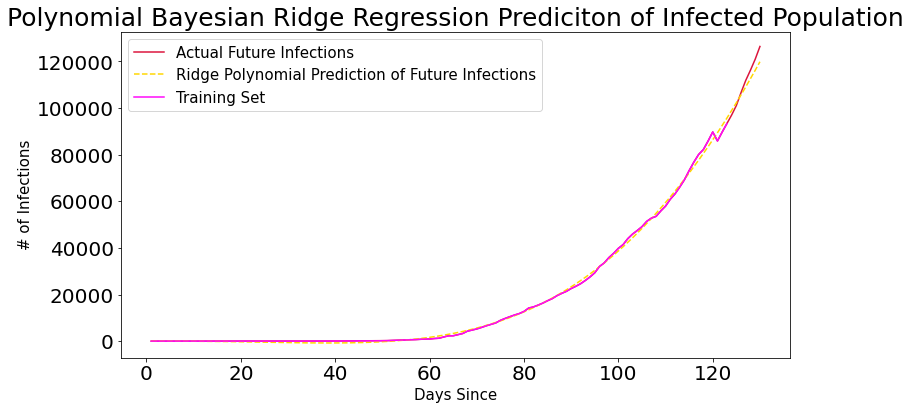

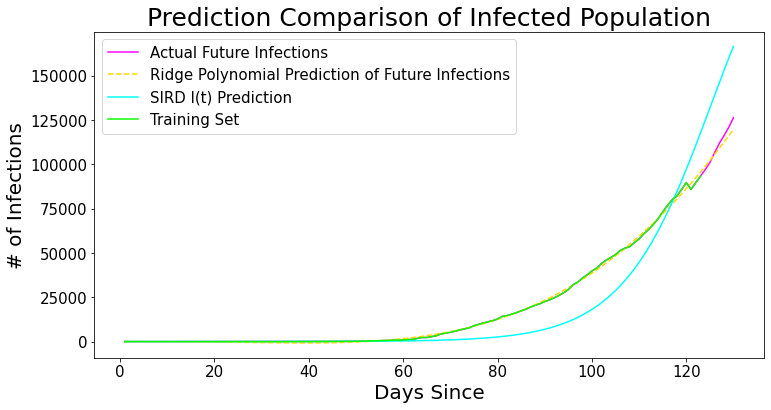

In [ ]:
japan_pop = 16000
us_pop = 1400000
indian_pop = 1000000
#beta, gamma, mu = analyzeSIRDtraining("US", us_pop,99)
beta, gamma, mu = analyzeSIRDtraining("India", indian_pop, 95)

In [ ]:
print("Re for SIRD Model :",(beta/(gamma+mu)))

Re for SIRD Model : 2.3425267669488092
